$$
\LaTeX macros
\newcommand{\pba}{{p^b_a}}
\newcommand{\de}{{\dot{e}}}
\newcommand{\dde}{{\ddot{e}}}
\newcommand{\pbd}{{p^b_d}}
\newcommand{\dpba}{{\dot{p}^b_a}}
\newcommand{\ddpba}{{\ddot{p}^b_a}}
\newcommand{\dpbd}{{\dot{p}^b_d}}
\newcommand{\ddpbd}{{\ddot{p}^b_d}}
\newcommand{\pag}{{p^a_g}}
\newcommand{\pav}{{p^a_v}}
\newcommand{\dpag}{{\dot{p}^a_g}}
\newcommand{\pai}{{p^a_i}}
\newcommand{\dpai}{{\dot{p}^a_i}}
\newcommand{\pbg}{{p^b_g}}
\newcommand{\dpbg}{{\dot{p}^b_g}}
\newcommand{\ddpbg}{{\ddot{p}^b_g}}
\newcommand{\pbi}{{p^b_i}}
\newcommand{\dpbi}{{\dot{p}^b_i}}
\newcommand{\ddpbi}{{\ddot{p}^b_i}}
\newcommand{\Rba}{{R^b_a}}
\newcommand{\dRba}{{\dot{R}{}^b_a}}
\newcommand{\ddRba}{{\ddot{R}{}^b_a}}
\newcommand{\Rab}{{R^a_b}}
\newcommand{\omaa}{{\omega^a_a}}
\newcommand{\domaa}{{\dot{\omega}{}^a_a}}
\newcommand{\Somaa}{{S\left(\omega^a_a\right)}}
\newcommand{\dSomaa}{{S\left(\dot{\omega}{}^a_a\right)}}
\newcommand{\Spag}{{S\left(p^a_g\right)}}
\newcommand{\Spai}{{S\left(p^a_i\right)}}
\newcommand{\nuaa}{{\nu^a_a}}
\newcommand{\dnuaa}{{\dot{\nu}{}^a_a}}
\newcommand{\Fb}{{F^b}}
\newcommand{\Fa}{{F^a}}
\newcommand{\Fg}{{F_g}}
\newcommand{\Fv}{{F_v}}
\newcommand{\Ng}{{N_g}}
\newcommand{\Nv}{{N_v}}
\newcommand{\Fe}{{F^{ext}}}
\newcommand{\Na}{{N^a}}
\newcommand{\iM}{{M^{-1}}}
\newcommand{\BM}{\left[\begin{matrix}}
\newcommand{\EBM}{\end{matrix}\right]}
\newcommand{\gamaa}{{\gamma^a_a}}
\newcommand{\dgamaa}{{\dot{\gamma}{}^a_a}}
\newcommand{\vx}{\vec{x}}
\newcommand{\vt}{\vec{\tau}}
\newcommand{\vn}{\vec{\nu}}
\newcommand{\T}{^\top}
\newcommand{\o}[1]{{\overline{#1}}}
\newcommand{\d}[2]{{\frac{\partial #1}{\partial #2}}}
\newcommand{\xpba}{{\,}^x{\!}p^b_a}
\newcommand{\ypba}{{\,}^y{\!}p^b_a}
$$


# Lab 04 - Control of a quadrotor - example of outer loop
In this exercise model of flying robot is specified with actuation system characteristic for quadrotor.
Than control algorithm for altitude and pose stabilisation is extended to stabilize position.

## The model of a flying robot
At the beginning let import all necessary libraries: 

In [1]:
from sympy import *
from sympy.plotting import plot
from sympy.matrices import matrix_multiply_elementwise as mme
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import functools

Next define all variables used in the equation of the motion and all necessary helper functions:

In [2]:
t = symbols('t')

# Flying robot
phi_, tta_, psi_ = symbols('\phi \\theta \psi', cls=Function)
phi, tta, psi = phi_(t), tta_(t), psi_(t)

m, Ix, Iy, Iz = symbols('m I_x I_y I_z') # mass and inertia
u_,v_,w_,p_,q_,r_ = symbols('u v w p q r', cls=Function)
u,v,w,p,q,r = u_(t),v_(t),w_(t),p_(t),q_(t),r_(t)
xpag, ypag, zpag = symbols('{\\\,}^x{\\!}p^a_g {\\\,}^y{\\!}p^a_g {\\\,}^z{\\!}p^a_g')

grav, rho, Vol = symbols('g \\rho_{air} V') # earth acceleration, air density, object volume
xpav, ypav, zpav = symbols('{\\\,}^x{\\!}p^a_v {\\\,}^y{\\!}p^a_v {\\\,}^z{\\!}p^a_v')
pav = Matrix([xpav,ypav,zpav])

# aerodynamical coeffiecients
uCd, vCd, wCd, pCd, qCd, rCd = symbols('{\\\,}^u{\\!}C_d {\\\,}^v{\\!}C_d {\\\,}^w{\\!}C_d {\\\,}^p{\\!}C_d {\\\,}^q{\\!}C_d {\\\,}^r{\\!}C_d')
uCl, vCl, pCl, qCl, rCl = symbols('{\\\,}^u{\\!}C_l {\\\,}^v{\\!}C_l {\\\,}^p{\\!}C_l {\\\,}^q{\\!}C_l {\\\,}^r{\\!}C_l')

tauu_,tauv_,tauw_,taup_,tauq_,taur_ = symbols('\\tau_u \\tau_v \\tau_w \\tau_p \\tau_q \\tau_r', cls=Function)
tauu,tauv,tauw,taup,tauq,taur = tauu_(t),tauv_(t),tauw_(t),taup_(t),tauq_(t),taur_(t)
tau = Matrix([tauu,tauv,tauw,taup,tauq,taur])

tauus,tauvs,tauws,taups,tauqs,taurs = symbols('\overline{\\tau}_u \overline{\\tau}_v \overline{\\tau}_w \overline{\\tau}_p \overline{\\tau}_q \overline{\\tau}_r', cls=Function)
taus = Matrix([tauus,tauvs,tauws,taups,tauqs,taurs])

us,vs,ws,ps,qs,rs = symbols('\o{u} \o{v} \o{w} \o{p} \o{q} \o{r}', constant=True)
gamaas = Matrix([us,vs,ws,ps,qs,rs])

Chi = Matrix([[phi,tta,psi]]).T
dChi = diff(Chi,t)

cN1, cN2, cN3, cN4, cN = symbols('c_{N1} c_{N2} c_{N3} c_{N4} c_{N}')
cF1, cF2, cF3, cF4, cF = symbols('c_{F1} c_{F2} c_{F3} c_{F4} c_{F}')
om1_, om2_, om3_, om4_ = symbols('\omega_1 \omega_2 \omega_3 \omega_4',cls=Function)
om1, om2, om3, om4 = om1_(t), om2_(t), om3_(t), om4_(t)
xpgE1, ypgE1, zpgE1 = symbols('{\\\,}^x{\\!}p^g_{E1} {\\\,}^y{\\!}p^g_{E1} {\\\,}^z{\\!}p^g_{E1}')
xpgE2, ypgE2, zpgE2 = symbols('{\\\,}^x{\\!}p^g_{E2} {\\\,}^y{\\!}p^g_{E2} {\\\,}^z{\\!}p^g_{E2}')
xpgE3, ypgE3, zpgE3 = symbols('{\\\,}^x{\\!}p^g_{E3} {\\\,}^y{\\!}p^g_{E3} {\\\,}^z{\\!}p^g_{E3}')
xpgE4, ypgE4, zpgE4 = symbols('{\\\,}^x{\\!}p^g_{E4} {\\\,}^y{\\!}p^g_{E4} {\\\,}^z{\\!}p^g_{E4}')
pgE1 = Matrix([xpgE1, ypgE1, zpgE1])
pgE2 = Matrix([xpgE2, ypgE2, zpgE2])
pgE3 = Matrix([xpgE3, ypgE3, zpgE3])
pgE4 = Matrix([xpgE4, ypgE4, zpgE4])
z_ax = Matrix([0,0,1])

x_, y_, z_ = symbols('x y z',cls=Function)
x, y, z = x_(t), y_(t), z_(t)
xs, ys, zs = symbols('\o{x} \o{y} \o{z}')
phis, ttas, psis = symbols('\o{\phi} \o{\\theta} \o{\psi}')
om1s,om2s,om3s,om4s = symbols('\o{\omega}_1 \o{\omega}_2 \o{\omega}_3 \o{\omega}_4')

xd,yd,zd,phid,ttad,psid = symbols('x_d y_d z_d \phi_d \\theta_d \psi_d')
eta = Matrix([x,y,z,phi,tta,psi])

In [3]:
def log_results(func):
    @functools.wraps(func)
    def w_dec(*args, **kwargs):
        res = func(*args, **kwargs)
        t_old = -1 if len(w_dec.t) == 0 else w_dec.t[-1]
        t_new = args[0]
        if t_new > t_old:
            w_dec.log.append(res)
            w_dec.t.append(args[0])
        else:
            f = filter(lambda x: x >= t_new, w_dec.t)
            idx = w_dec.t.index(next(f))
            w_dec.log = w_dec.log[0:idx]+[res]
            w_dec.t = w_dec.t[0:idx]+[t_new]
        return res
    w_dec.log = []
    w_dec.t = []
    return w_dec


Sk = lambda v: Matrix([[0, -v[2], v[1]],[v[2], 0, -v[0]],[-v[1], v[0], 0]])

def Rx(a):
    return Matrix([[1,0,0],
                  [0,cos(a),-sin(a)],
                  [0,sin(a),cos(a)]])

def Ry(a):
    return Matrix([[cos(a),0,sin(a)],
                  [0,1,0],
                  [-sin(a),0,cos(a)]])

def Rz(a):
    return Matrix([[cos(a),-sin(a),0],
                  [sin(a),cos(a),0],
                  [0,0,1]])

def Jac(R,dChi=dChi):
    dR = (diff(R,t))
    Sw = (R.T @ dR)
    omsw = Matrix([[Sw[(2,1)]],[Sw[(0,2)]],[Sw[(1,0)]]])
    iJ = simplify(omsw.jacobian(dChi))
    J = simplify(iJ.inverse())
    return J

def plot_results(sim,ctrl,traj):
    control = np.array([ctrl.log[ctrl.t.index(time)] for time in sim.t]).T
    trajectory = np.array([traj.log[traj.t.index(time)] for time in sim.t]).T
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(3,2,1)
    ax1.plot(sim.t,sim.y[0],label='x')
    ax1.plot(sim.t,sim.y[1],label='y')
    ax1.plot(sim.t,sim.y[2],label='z')
    ax1.legend(loc='best')
    ax1 = fig1.add_subplot(3,2,2)
    ax1.plot(sim.t,sim.y[3],label='$\phi$')
    ax1.plot(sim.t,sim.y[4],label='$\\theta$')
    ax1.plot(sim.t,sim.y[5],label='$\psi$')
    ax1.legend(loc='best')
    ax1 = fig1.add_subplot(3,2,3)
    ax1.plot(sim.t,sim.y[6],label='$u$')
    ax1.plot(sim.t,sim.y[7],label='$v$')
    ax1.plot(sim.t,sim.y[8],label='$w$')
    ax1.legend(loc='best')
    ax1 = fig1.add_subplot(3,2,4)
    ax1.plot(sim.t,sim.y[9],label='$p$')
    ax1.plot(sim.t,sim.y[10],label='$q$')
    ax1.plot(sim.t,sim.y[11],label='$r$')
    ax1.legend(loc='best')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(1,1,1)
    ax2.plot(sim.t,control[0],label='$\omega_1$')
    ax2.plot(sim.t,control[1],label='$\omega_2$')
    ax2.plot(sim.t,control[2],label='$\omega_3$')
    ax2.plot(sim.t,control[3],label='$\omega_4$')
    ax2.legend(loc='best')
#     ax2.set_ylim([244,246])
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(1,1,1)
    ax3.plot(sim.t,sim.y[0]-trajectory[0],label='$x-x_d$')
    ax3.plot(sim.t,sim.y[1]-trajectory[1],label='$y-y_d$')
    ax3.plot(sim.t,sim.y[2]-trajectory[2],label='$z-z_d$')
    ax3.plot(sim.t,sim.y[3]-trajectory[3],label='$\phi-\phi_d$')
    ax3.plot(sim.t,sim.y[4]-trajectory[4],label='$\\theta-\\theta_d$')
    ax3.plot(sim.t,sim.y[5]-trajectory[5],label='$\psi-\psi_d$')
    ax3.legend(loc='best')
    fig4 = plt.figure()
    ax4 = fig4.add_subplot(1,1,1)
    ax4.plot(sim.y[0],sim.y[1])
    ax4.plot(trajectory[0],trajectory[1])
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.set_aspect('equal')

Using [symbolic expression](https://www.sympy.org/en/index.html) let define componenets of the equations of motion, notice simplification of mass matrix $M$ and be patient:

In [4]:
Rba = (Rz(psi) @ Ry(tta) @ Rx(phi)) # RPY
Rab = Rba.T
Jba = Jac(Rba)
Jab = simplify(Jba.inverse())
Eta = Rba.col_join(zeros(3)).row_join(zeros(3).col_join(Jba))
iEta = simplify(Eta.inverse())

I, nu, omaa, pag = diag(Ix,Iy,Iz), Matrix([u,v,w]), Matrix([p,q,r]), Matrix([xpag,ypag,zpag]) # inertia tensor, linear and angular velocities, vector of position of the center of gravity in the local frame
M = (m*eye(3)).row_join(-m * Sk(pag)).col_join((m * Sk(pag)).row_join(I))
# iM = simplify(M.inv()) # symbolic inversion of a matrix is very time consumming
iM = simplify(M.subs({xpag:0,ypag:0,zpag:0}).inv())
C = (m*Sk(omaa)).row_join(-m*Sk(omaa)*Sk(pag)).col_join((m*Sk(pag)*Sk(omaa)).row_join(-Sk(omaa)*I))
# gravity
Fbg = Matrix([0,0,-m*grav])
Fag = Rab*Fbg
Nag = Sk(pag)*Fag
Gag = Fag.col_join(Nag)
# bouyancy
Fbv = Matrix([0,0,rho*grav*Vol])
Fav = Rab*Fbv
Nav = Sk(pav)*Fav
Gav = Fav.col_join(Nav)
# restoring forces
Gar = Gag+Gav
gamaa, sgamaa = nu.col_join(omaa), Matrix([sign(u),sign(v),sign(w),sign(p),sign(q),sign(r)])
Cad = Matrix([[uCd,0,0,0,0,0],[0,vCd,0,0,0,0],[0,0,wCd,0,0,0],[0,0,0,pCd,0,0],[0,0,0,0,qCd,0],[0,0,0,0,0,rCd]])
Cal = Matrix([[0,0,0,0,0,0],[0,0,0,0,0,0],[uCl,vCl,0,pCl,qCl,rCl],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
Gaa = -Cad * mme(sgamaa,mme(gamaa,gamaa)) + Cal * mme(gamaa,gamaa)

## Exercise 1:

### Quadrotor actuation system

<img src="./gfx/quadrotor2.svg"/>

The equation of the actuation system are:

$$\tau = \BM {}^{u,v,w}\tau \\ {}^{p,q,r}\tau \EBM= \BM 0 \\ 0 \\ {}^w\tau \\ {}^p\tau \\{}^q\tau \\{}^r\tau \EBM$$

$$
\begin{align}
{}^{u,v,w}\tau &= \sum{F_{E_i}}\\
{}^{p,q,r}\tau &= \sum{S\left(p^g_{E_i}\right)F_{E_i}} + \sum{N_{E_i}}\\
N_{E_i} &= \BM 0 & 0 -c_{N} \omega_i\EBM\T \\
F_{E_i} &= c_{F} \omega_i \BM 0 & 0 & 1 \\ \EBM\T
\end{align}
$$

Using already defined symbols define $\tau$ for quadrotor as variable `tau_quad`. Remember about different directions of rotation of the opposite engines.
Also define equations of kinematics and dynamics (use simplify function for simplification of the equations):

### Use solution from Lab 03

In [5]:
## your code here

xpgE4, ypgE4, zpgE4 = symbols('{\\\,}^x{\\!}p^g_{E4} {\\\,}^y{\\!}p^g_{E4} {\\\,}^z{\\!}p^g_{E4}')
pgE1 = Matrix([xpgE1, ypgE1, zpgE1])


Fe1 = cF*om1*Matrix([0,0,1])
Fe2 = cF*om2*Matrix([0,0,1])
Fe3 = cF*om3*Matrix([0,0,1])
Fe4 = cF*om4*Matrix([0,0,1])
Ne1 = Matrix([0,0,-cN*om1])
Ne2 = Matrix([0,0,-cN*om2])
Ne3 = Matrix([0,0,-cN*om3])
Ne4 = Matrix([0,0,-cN*om4])
pqr_tau = Sk(pgE1)*Fe1 + Sk(pgE2)*Fe2 + Sk(pgE3)*Fe3 + Sk(pgE4)*Fe4 + Ne1 - Ne2 + Ne3 - Ne4
uvw_tau = Fe1 + Fe2 + Fe3 + Fe4

tau_quad = uvw_tau.col_join(pqr_tau)
display(tau_quad)

Matrix([
[                                                                                                                                                         0],
[                                                                                                                                                         0],
[                                                                             c_{F}*\omega_1(t) + c_{F}*\omega_2(t) + c_{F}*\omega_3(t) + c_{F}*\omega_4(t)],
[ c_{F}*{\,}^y{\!}p^g_{E1}*\omega_1(t) + c_{F}*{\,}^y{\!}p^g_{E2}*\omega_2(t) + c_{F}*{\,}^y{\!}p^g_{E3}*\omega_3(t) + c_{F}*{\,}^y{\!}p^g_{E4}*\omega_4(t)],
[-c_{F}*{\,}^x{\!}p^g_{E1}*\omega_1(t) - c_{F}*{\,}^x{\!}p^g_{E2}*\omega_2(t) - c_{F}*{\,}^x{\!}p^g_{E3}*\omega_3(t) - c_{F}*{\,}^x{\!}p^g_{E4}*\omega_4(t)],
[                                                                            -c_{N}*\omega_1(t) + c_{N}*\omega_2(t) - c_{N}*\omega_3(t) + c_{N}*\omega_4(t)]])

In [6]:
## your code here
Kin = simplify(Eta*gamaa)
display(Kin)
Dyn = simplify(iM*(tau_quad+Gar-Gaa))
display(Dyn)
diff_state = Kin.col_join(Dyn)

Matrix([
[ (sin(\phi(t))*sin(\psi(t)) + sin(\theta(t))*cos(\phi(t))*cos(\psi(t)))*w(t) + (sin(\phi(t))*sin(\theta(t))*cos(\psi(t)) - sin(\psi(t))*cos(\phi(t)))*v(t) + u(t)*cos(\psi(t))*cos(\theta(t))],
[-(sin(\phi(t))*cos(\psi(t)) - sin(\psi(t))*sin(\theta(t))*cos(\phi(t)))*w(t) + (sin(\phi(t))*sin(\psi(t))*sin(\theta(t)) + cos(\phi(t))*cos(\psi(t)))*v(t) + u(t)*sin(\psi(t))*cos(\theta(t))],
[                                                                                                   -u(t)*sin(\theta(t)) + v(t)*sin(\phi(t))*cos(\theta(t)) + w(t)*cos(\phi(t))*cos(\theta(t))],
[                                                                                                                   p(t) + q(t)*sin(\phi(t))*tan(\theta(t)) + r(t)*cos(\phi(t))*tan(\theta(t))],
[                                                                                                                                                        q(t)*cos(\phi(t)) - r(t)*sin(\phi(t))],
[                         

Matrix([
[                                                                                                                                                                                                                                                                                                                                      (-V*\rho_{air}*g*sin(\theta(t)) + g*m*sin(\theta(t)) + {\,}^u{\!}C_d*u(t)**2*sign(u(t)))/m],
[                                                                                                                                                                                                                                                                                                             (V*\rho_{air}*g*sin(\phi(t))*cos(\theta(t)) - g*m*sin(\phi(t))*cos(\theta(t)) + {\,}^v{\!}C_d*v(t)**2*sign(v(t)))/m],
[                                                                                                     (V*\rho_{air}*g*cos(\phi(t))*cos(\theta(t)) + c_{

### Define parameters of the quadrotor:


In [7]:
params = {xs:0,ys:0,zs:0,phis:0,ttas:0,psis:0,us:0,vs:0,ws:0,ps:0,qs:0,rs:0}
# params = {phis:0,ttas:0,psis:0,us:0,vs:0,ws:0,ps:0,qs:0,rs:0}
params.update({uCd:0.01,vCd:0.01,wCd:0.01,pCd:0.01,qCd:0.01,rCd:0.01})
params.update({uCl:0.0,vCl:0.0,pCl:0.0,qCl:0.0,rCl:0.0})
params.update({Vol:0,rho:0,grav:9.81,m:1,Ix:0.1,Iy:0.1,Iz:0.1})
params.update({xpag:0,ypag:0,zpag:0})
params.update({cF:0.01,cN:0.001})
arm_len = 0.2
params.update({xpgE1:arm_len,ypgE1:0,zpgE1:0})
params.update({xpgE2:0,ypgE2:arm_len,zpgE2:0})
params.update({xpgE3:-arm_len,ypgE3:0,zpgE3:0})
params.update({xpgE4:0,ypgE4:-arm_len,zpgE4:0})
B = diff_state.jacobian(Matrix([om1,om2,om3,om4]))

### Define functions for numerical calculations:

In [8]:
F_num = lambdify((phi,tta,psi,u,v,w,p,q,r,om1,om2,om3,om4),diff_state.subs(params))
M_num = M.subs(params)
G_num = lambdify((phi,tta,u,v,w,p,q,r),(Gar+Gaa).subs(params))
C_num = lambdify((p,q,r),C.subs(params))
Eta_num = lambdify((phi,tta,psi),Eta)
iB_num = np.array(B.subs(params)[8:12,0:4].inv())
Rab_num = lambdify((phi,tta,psi),Rab)
Rba_num = lambdify((phi,tta,psi),Rba)
Jba_num = lambdify((phi,tta,psi),Jba)

### Define numerical model of quadrotor and trajectory generator:

In [9]:
def quadrotor(t,state):
    tr = traj(t,state)
    engines_omega = ctrl(t,state,tr)
    x,y,z,phi,tta,psi,u,v,w,p,q,r = state
    om1,om2,om3,om4 = engines_omega
    diff_state = np.ndarray.tolist(F_num(phi,tta,psi,u,v,w,p,q,r,om1,om2,om3,om4).T)[0]
    return diff_state

## Exercise 2:

Define controller for altitute and pose stabilisation.
Let start with equation of motion reminder:

$$
\begin{align}
\dpba &= \Rba \nuaa \\
\dot{\chi} &= J \omaa \\
\dot{\eta} &= \BM \dpba \\ \dot{\chi} \EBM \\
H &=\BM \Rba & 0 \\ 0 & J\EBM \\
\dot{\eta} &= H \gamaa\\
\dgamaa &= M^{-1} \left(\tau +\Gamma - C \gamaa \right)
\end{align}
$$

### Control objective:
Stabilize $z,\phi,\theta,\psi$, notice, that as a consequance the quadrotor will achive constatnt linear velocities for non-zero $\phi$ and $\theta$.

### Constraints

The controller can generate only four control signals. Desired accelerations in $x$ and $y$ axes in the local frame ($\dot{u},\dot{v}$) need to be equal to zero, because of the form of $\tau$.

### Kinematics controller

<img src="./gfx/vectors_error.svg" style='height:200px'/>

$$
\begin{align}
e &= \eta_d - \eta \\
\dot{e} &= \dot{\eta}_d - \dot{\eta} \\
\eta_d & \triangleq const \\
\dot{e} &= - \dot{\eta} \\
\end{align}
$$

#### Control law for kinematcs
$$
\begin{align}
\dot{\eta} &= K_{kin} e \\
\dot{e} &= - K_{kin} e
\end{align}
$$

From the kinematic equation:
$$
\gamaa_d = H^{-1} \dot{\eta}
$$

### Dynamics controller

$$
\begin{align}
e_\gamma &= \gamaa_d - \gamaa\\
\dot{e}_\gamma &= \dgamaa_d - \dgamaa \\
\gamaa_d &\triangleq const \\
\dot{e}_\gamma &= - \dgamaa \\
\end{align}
$$

#### Control law for dynamics

$$
\begin{align}
\tau &= M K_{dyn} e_\gamma  - \Gamma + C \gamaa \\
\dgamaa &= M^{-1} \left(M K_{dyn} e_\gamma - \Gamma + C \gamaa  +\Gamma - C \gamaa \right) \\
\dgamaa &= M^{-1} M  K_{dyn} e_\gamma \\
\dgamaa &=  K_{dyn} e_\gamma \\
\dot{e}_\gamma &= -K_{dyn} e_\gamma
\end{align}
$$

Because of the constraints in actuation system the control objective do not consider positions in $X$ and $Y$ axes. Main consequance of that are the following assumtions:
$$
\begin{align}
\xpba {}_d &= \xpba \\
\ypba {}_d &= \ypba.
\end{align}
$$ 
Also the velocities $u$ and $v$ are not controlled directly (!), hence the rotational velocities of the engines can be calculated using inverse of the part of the input matrix $B$, where:
$$
\begin{align}
\tau = B \BM \omega_1 \\ \omega_2 \\ \omega_3 \\ \omega_4 \EBM
\end{align}
$$
Such case can be practicly used for remote control of quadrotors. 

### Use solution from Lab 03

## Exercise 3:

Implement outer loop.

The proposed control algorithm for the outer loop is to rotate the robot towards the desired destination at a certain angle $\kappa$ (control parameter), and when the robot approaches the destination, this angle should decrease.

Let define the axis of desired rotation $\alpha^b$ in the global frame as:
$$
\begin{align}
e =& \pbd-\pba \\
e_p =& \dpbd - \dpba \\
\alpha^b =& \BM 0 \\ 0 \\ 1\EBM \times \left(e_p + \dot{e}_p\right)
\end{align}
$$

The angle of rotation $\kappa$ in the proposed algorithm is a design parameter independent of the distance from the desired position. So the $\alpha^b$ axis should be normalized.

$$
\begin{align}
\hat{\alpha}^b = \frac{\alpha^b}{\left\lVert{\alpha^b}\right\rVert}
\end{align}
$$


The elements of the axis of rotation expressed in the local frame can be interpreted as angular velocities:

$$
\begin{align}
\hat{\alpha}^a = \Rab \hat{\alpha}^b \sim \BM p \\ q \\ r \EBM
\end{align}
$$

A sigmoid function is proposed to reduce the $\kappa$ when the robot is approaching its destination:

$$
\begin{align}
k_\kappa = \frac{\left\rVert e_p+ \dot{e}_p\right\rVert}{\left\rVert e_p+ \dot{e}_p\right\rVert + \delta}
\end{align}
$$

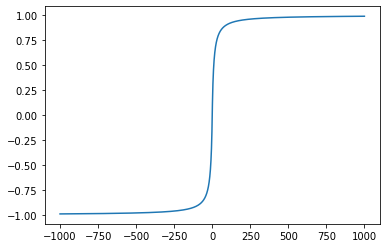

In [10]:
# definition and visualisation of the proposed sigmoid function
def sigmoid(x,delta):
    return (x/(np.abs(x)+delta))  

delta = 10
x = np.array(range(-10000,10000))/10
plt.plot(x,sigmoid(x,delta))

For the inner loop controller it is nessessary to obtain desired angles of rotation expressed in the global frame $\chi$. Because of that the desired angular velocities should be expressed as rate of changes of Euler's angles:

$$
\begin{align}
\dot{\chi}_d = J^b_a \cdot \kappa \cdot k_\kappa \cdot \hat{\alpha}^a
\end{align}
$$


Finally let assume that to obtain desired Euler angles, the desired rate of change of the angles $\dot{\chi}_d$ should last $1 s$:

$$
\begin{align}
\chi_d = \dot{\chi}_d \cdot 1
\end{align}
$$

Implement the proposed outer loop algorithm and try to answer the following questions.

1. Is it neseccary to use all 3 desired Euler angles calculated in outer loop? Motivate your answer.
2. Is it possible to use proposed algorithm to implement trajectory following task? Alternatively, under what conditions?

In [19]:
Matrix([[0], [0], [0]])

Matrix([
[0],
[0],
[0]])

In [116]:
@log_results
def ctrl(t,state,traj):
    x,y,z,phi,tta,psi,u,v,w,p,q,r = state
    gamaa = Matrix([u,v,w,p,q,r])
    xd,yd,zd,phid,ttad,psid,ud,vd,wd,pd,qd,rd = traj
    Mn = M_num
    Gn = G_num(phi,tta,u,v,w,p,q,r)
    Cn = C_num(p,q,r)
    Etan = Eta_num(phi,tta,psi)
    iBn = iB_num
    Rabn = Rab_num(phi,tta,psi)
    Rban = Rba_num(phi,tta,psi)
    Jban = Jba_num(phi,tta,psi)


    #error
    ep = np.array([xd-x, yd - y, zd - z])
    # derivative of error
    edp = -1*Rabn@np.array([u, v, w])
    a = np.array([0, 0, 1])
    b = ep + edp
    ab = np.cross(a, b, axis=0)
    print(ab)
    print(np.linalg.norm(ab))
    adb = ab/np.linalg.norm(ab)
    ada = Rabn * adb 
    
    Xd = Jban * K * sigmoid(K, 10)*ada
   ## your code here
    gamad = Matrix([ud,vd,wd,pd,qd,rd])
    #Kdyn = np.random.rand(6, 6)
    Kdyn = np.eye(6, dtype=int)
    ey = gamad - gamaa
    tau = Mn @ Kdyn @ ey - Gn + Cn @ gamaa
        
    engines_omega = iBn@tau[2:6]
    return engines_omega


In [113]:
np.linalg.norm(np.array([1,2]))

2.23606797749979

## Exerciese 4:
Perform simulations for different trajectories and initial state. Analyze the results.

In [111]:
@log_results
def traj(t,state):
    xd = 10
    yd = 20
    zd = 0
    phid = 0
    ttad = 0.1
    psid = 1
    ud = 0
    vd = 0
    wd = 0
    pd = 0
    qd = 0
    rd = 0
    traj = [xd,yd,zd,phid,ttad,psid,ud,vd,wd,pd,qd,rd]
    return traj

In [117]:
state0 = [10,-7,1,0.1,-0.2,-0.3,0,0,0,0,0,0]
sim = solve_ivp(quadrotor,[0,100],state0,max_step=1)
plot_results(sim,ctrl,traj)    

[-27.   0.   0.]
27.0


NameError: name 'K' is not defined